# Compare prediction

In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import json
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import string
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from tree.parameters import Ts

In [2]:
hbi_unc_df = pd.read_csv("../data/hbi_unc.csv")

with open("../data/splits/random.json", "r") as f:
    train_inds, test_inds = json.load(f)

test_df = hbi_unc_df.loc[test_inds, :]
test_df = test_df.reset_index(drop=True)
# empirical_df = pd.read_csv("../data/hbi_prediction_empirical.csv")
# empirical_df = empirical_df.loc[test_inds, :]
# empirical_df = empirical_df.reset_index(drop=True)

# Load test results

In [5]:
sidt_df_dict = {}
fractions = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for frac in fractions:
    sidt_df = pd.read_csv(f"../models/split-random_run-basecase/frac-{frac}/test.csv")
    sidt_df_dict[frac] = sidt_df

# Plot: bounded uncertainty

In [6]:
test_df.columns

Index(['radical_smiles', 'resonance_radical_smiles',
       'resonance_radical_num_rotatable_bonds', 'radical_H298 (kcal/mol)',
       'radical_Sint298 (cal/mol/K)', 'radical_source',
       'radical_level_of_theory', 'radical_Cp300 (cal/mol/K)',
       'radical_Cp400 (cal/mol/K)', 'radical_Cp500 (cal/mol/K)',
       'radical_Cp600 (cal/mol/K)', 'radical_Cp800 (cal/mol/K)',
       'radical_Cp1000 (cal/mol/K)', 'radical_Cp1500 (cal/mol/K)',
       'closed_shell_smiles', 'closed_shell_H298 (kcal/mol)',
       'closed_shell_Cp300 (cal/mol/K)', 'closed_shell_Cp400 (cal/mol/K)',
       'closed_shell_Cp500 (cal/mol/K)', 'closed_shell_Cp600 (cal/mol/K)',
       'closed_shell_Cp800 (cal/mol/K)', 'closed_shell_Cp1000 (cal/mol/K)',
       'closed_shell_Cp1500 (cal/mol/K)', 'closed_shell_Sint298 (cal/mol/K)',
       'closed_shell_thermo_comment', 'closed_shell_thermo_source',
       'HBI_H298 (kcal/mol)', 'HBI_Sint298 (cal/mol/K)',
       'HBI_Cp300 (cal/mol/K)', 'HBI_Cp400 (cal/mol/K)',
       '

In [13]:
temp_dict = {
    "fraction of training": [],
}

for column in test_df.columns:
    if column.startswith("HBI_"):
        temp_dict[column] = []

for frac, sidt_df in sidt_df_dict.items():
    temp_dict["fraction of training"].append(frac)
    for column in test_df.columns:
        if column.startswith("HBI_"):
            pred_unc = sidt_df["unc_"+column]
            true_err = (sidt_df[column] - test_df[column]).abs()
            temp_dict[column].append(sum(pred_unc >= true_err) / len(pred_unc))

bounded_df = pd.DataFrame(temp_dict)
bounded_df

,fraction of training,HBI_H298 (kcal/mol),HBI_Sint298 (cal/mol/K),HBI_Cp300 (cal/mol/K),HBI_Cp400 (cal/mol/K),HBI_Cp500 (cal/mol/K),HBI_Cp600 (cal/mol/K),HBI_Cp800 (cal/mol/K),HBI_Cp1000 (cal/mol/K),HBI_Cp1500 (cal/mol/K)
0,0.01,0.523466,0.465704,0.750903,0.732852,0.732852,0.779783,0.761733,0.747292,0.761733
1,0.05,0.581227,0.631769,0.776173,0.740072,0.707581,0.707581,0.711191,0.747292,0.783394
2,0.10,0.620939,0.624549,0.801444,0.747292,0.732852,0.743682,0.754513,0.761733,0.779783
3,0.20,0.649819,0.649819,0.805054,0.711191,0.732852,0.768953,0.761733,0.772563,0.808664
4,0.30,0.620939,0.678700,0.758123,0.711191,0.743682,0.758123,0.765343,0.783394,0.765343
5,0.40,0.653430,0.631769,0.801444,0.779783,0.790614,0.783394,0.779783,0.805054,0.812274
6,0.50,0.667870,0.613718,0.815884,0.772563,0.776173,0.779783,0.797834,0.823105,0.801444
7,0.60,0.718412,0.631769,0.805054,0.790614,0.794224,0.783394,0.801444,0.815884,0.830325
8,0.70,0.685921,0.664260,0.841155,0.830325,0.787004,0.750903,0.801444,0.812274,0.826715
9,0.80,0.682310,0.638989,0.837545,0.772563,0.768953,0.747292,0.768953,0.815884,0.768953


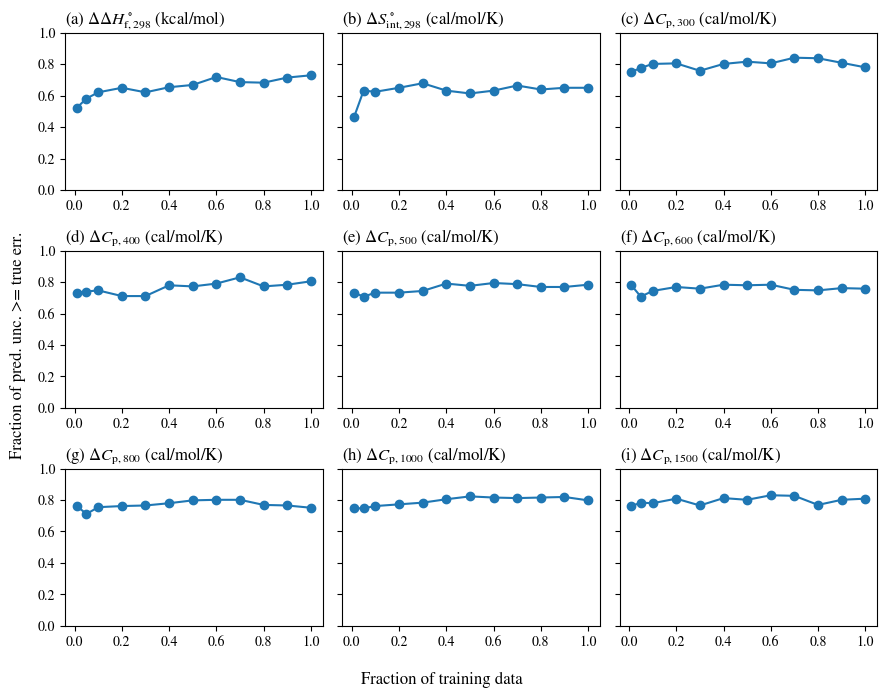

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
bins = 20

ax = axs.flat[0]
label = "HBI_H298 (kcal/mol)"
ax.plot(bounded_df["fraction of training"], bounded_df[label], "-o")
ax.set_ylim([0, 1])
ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

ax = axs.flat[1]
label = "HBI_Sint298 (cal/mol/K)"
ax.plot(bounded_df["fraction of training"], bounded_df[label], "-o")
ax.set_ylim([0, 1])
ax.set_title("(b) $\Delta S^\circ_\mathrm{int,298}$ (cal/mol/K)", loc="left")

for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
    label = f"HBI_Cp{T} (cal/mol/K)"
    ax.plot(bounded_df["fraction of training"], bounded_df[label], "-o")
    ax.set_ylim([0, 1])
    ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

fig.supylabel(f"Fraction of pred. unc. >= true err.")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
# fig.savefig("../figures/test_empirical_error_hist.pdf", bbox_inches="tight")